In [ ]:
# Install dependencies
!pip install sentence-transformers textblob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [ ]:
from google.colab import files
uploaded = files.upload()   # select the file you downloaded, e.g. "kdrama.csv"

import pandas as pd
df = pd.read_csv("kdrama_DATASET.csv")   # use the exact filename shown after upload
print(df.shape)
print(df.columns)
df.head()


Saving kdrama_DATASET.csv to kdrama_DATASET (1).csv
(350, 9)
Index(['Rank', 'Title', 'Year of release', 'Number of Episodes', 'Rating',
       'Description', 'Genre', 'Tags', 'Actors'],
      dtype='object')


,Rank,Title,Year of release,Number of Episodes,Rating,Description,Genre,Tags,Actors
0,#1,Move to Heaven,2021,10,9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...","Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju..."
1,#2,Twinkling Watermelon,2023,16,9.2,"In 2023, high school student Eun Gyeol, a CODA...","Romance, Youth, Drama, Fantasy","Time Travel, Child From The Future, Sign Langu...","Ha Eun-Gyeol, Ha Yi-Chan, Choi Se-Kyung, Yoon ..."
2,#3,Moving,2023,20,9.1,"Kim Bong Seok, Jang Hui Su, and Lee Gang Hun, ...","Action, Thriller, Mystery, Supernatural","Graphic Violence, Supernatural Power, Multiple...","Ryu Seung Ryong, Han Hyo Joo, Zo In Sung"
3,#4,The Trauma Code: Heroes on Call,2025,8,9.1,"Baek Gang Hyeok, a genius trauma surgeon with ...","Action, Comedy, Drama, Medical","Surgeon Male Lead, Hospital Setting, Mentor-Me...","Ju Ji Hoon, Choo Young Woo, Ha Young, Yoon Gyu..."
4,#5,Flower of Evil,2020,16,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ..."


In [ ]:
# Flexible column mapping: rename to a standard schema if present
col_map_candidates = {
    'title': ['Title', 'title', 'Drama_Name', 'Drama Name', 'Name'],
    'year': ['Year', 'Released Year', 'year', 'Release Year'],
    'episodes': ['Episodes', 'Episode', 'episodes'],
    'rating': ['Rating', 'Score', 'rating'],
    'description': ['Description', 'Plot', 'Synopsis', 'description'],
    'genre': ['Genre', 'Genres', 'genre'],
    'language': ['Language', 'Lang', 'language', 'Country']  # fallback to Country if Language missing
}

def pick_col(df, candidates, default=None):
    for c in candidates:
        if c in df.columns:
            return c
    return default

std_cols = {k: pick_col(df, v) for k, v in col_map_candidates.items()}

# Create a clean dataframe with standardized names
df_clean = pd.DataFrame({
    'title': df[std_cols['title']] if std_cols['title'] else df.iloc[:,0],
    'year': df[std_cols['year']] if std_cols['year'] else np.nan,
    'episodes': df[std_cols['episodes']] if std_cols['episodes'] else np.nan,
    'rating': df[std_cols['rating']] if std_cols['rating'] else np.nan,
    'description': df[std_cols['description']] if std_cols['description'] else "",
    'genre': df[std_cols['genre']] if std_cols['genre'] else "",
    'language': df[std_cols['language']] if std_cols['language'] else ""
})

# Basic cleaning
for c in ['title', 'description', 'genre', 'language']:
    df_clean[c] = df_clean[c].fillna("").astype(str).str.strip()

for c in ['year', 'episodes', 'rating']:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

df = df_clean.drop_duplicates(subset=['title']).reset_index(drop=True)
print("Normalized columns:", df.columns.tolist())
df.head()


Normalized columns: ['title', 'year', 'episodes', 'rating', 'description', 'genre', 'language']


,title,year,episodes,rating,description,genre,language
0,Move to Heaven,NaN,NaN,9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family",
1,Twinkling Watermelon,NaN,NaN,9.2,"In 2023, high school student Eun Gyeol, a CODA...","Romance, Youth, Drama, Fantasy",
2,Moving,NaN,NaN,9.1,"Kim Bong Seok, Jang Hui Su, and Lee Gang Hun, ...","Action, Thriller, Mystery, Supernatural",
3,The Trauma Code: Heroes on Call,NaN,NaN,9.1,"Baek Gang Hyeok, a genius trauma surgeon with ...","Action, Comedy, Drama, Medical",
4,Flower of Evil,NaN,NaN,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama",


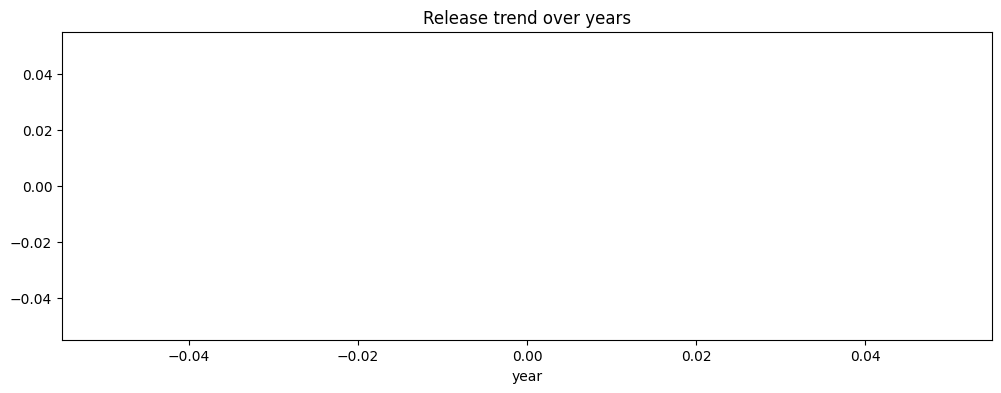

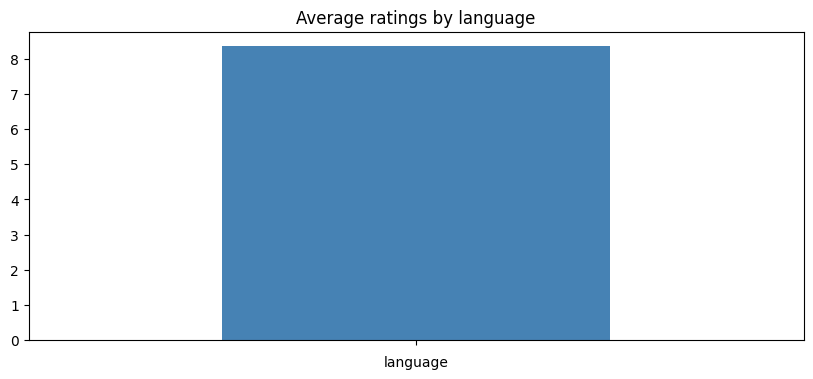

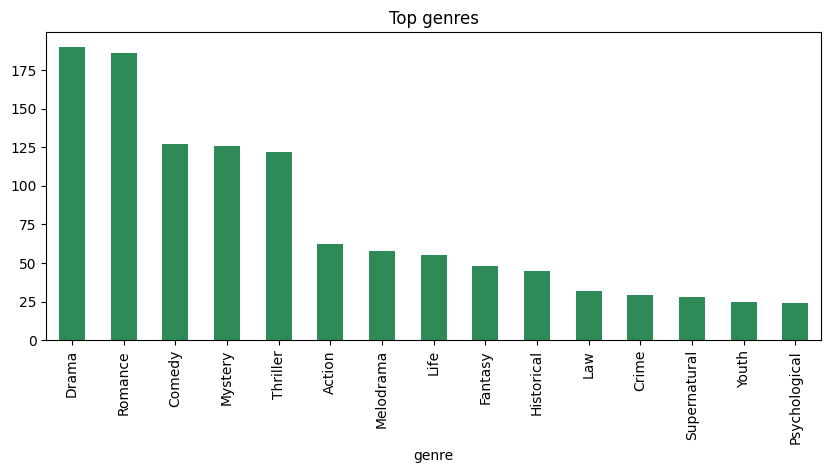

In [ ]:
plt.figure(figsize=(12,4))
df['year'].dropna().value_counts().sort_index().plot(kind='line', color='tomato')
plt.title("Release trend over years")
plt.show()

plt.figure(figsize=(10,4))
df.groupby('language')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='steelblue')
plt.title("Average ratings by language")
plt.show()

plt.figure(figsize=(10,4))
df['genre'].str.split(',').explode().str.strip().value_counts().head(15).plot(kind='bar', color='seagreen')
plt.title("Top genres")
plt.show()


In [ ]:
# Sentiment polarity on description
def get_sentiment_label(text):
    p = TextBlob(text).sentiment.polarity
    if p > 0.2: return "positive"
    if p < -0.2: return "negative"
    return "neutral"

df['sentiment'] = df['description'].apply(get_sentiment_label)

# Unified text feature: genre + description + language + sentiment
df['features_text'] = (
    df['genre'].fillna("") + " | " +
    df['language'].fillna("") + " | " +
    df['sentiment'].fillna("") + " | " +
    df['description'].fillna("")
)


In [ ]:
# Multilingual semantic embeddings (much stronger than TF-IDF)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(df['features_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)

# Cosine similarity matrix
sim_matrix = cosine_similarity(embeddings, embeddings)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def recommend_titles(title, df, sim_matrix, top_k=10):
    # Look up index safely
    matches = df.index[df['title'].str.lower() == title.lower()].tolist()
    if not matches:
        return []
    idx = matches[0]

    scores = list(enumerate(sim_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    recs = []
    for j, s in scores[1:top_k+1]:
        recs.append({'title': df.iloc[j]['title'], 'score': float(s)})
    return recs

# Example
seed = "The Tale of Nokdu"  # change as you like
recs = recommend_titles(seed, df, sim_matrix, top_k=10)
recs[:5]


[{'title': 'Hide', 'score': 0.6120591163635254},
 {'title': 'Bitch X Rich', 'score': 0.5949466228485107},
 {'title': 'Kokdu: Season of Deity', 'score': 0.591451108455658},
 {'title': 'Flex X Cop', 'score': 0.5794633626937866},
 {'title': 'High School Return of a Gangster', 'score': 0.5778119564056396}]

In [ ]:
# Overlap-based metrics
def precision_at_k(recommended_titles, relevant_titles, k=5):
    rec_at_k = [r['title'] for r in recommended_titles[:k]]
    hits = len(set(rec_at_k) & set(relevant_titles))
    return hits / max(k, 1)

def recall_at_k(recommended_titles, relevant_titles, k=5):
    rec_at_k = [r['title'] for r in recommended_titles[:k]]
    hits = len(set(rec_at_k) & set(relevant_titles))
    return hits / max(len(relevant_titles), 1)

def ndcg_at_k(recommended_titles, relevant_titles, k=5):
    rec_at_k = [r['title'] for r in recommended_titles[:k]]
    dcg = 0.0
    for i, t in enumerate(rec_at_k):
        if t in relevant_titles:
            dcg += 1.0 / np.log2(i + 2)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(relevant_titles), k)))
    return (dcg / idcg) if idcg > 0 else 0.0

# Helper: auto-generate a plausible relevant set from genre + language
def auto_relevant_set(seed_title, df, max_size=10):
    row = df[df['title'].str.lower() == seed_title.lower()]
    if row.empty:
        return []
    g = set([x.strip().lower() for x in row.iloc[0]['genre'].split(',') if x.strip()])
    lang = row.iloc[0]['language'].strip().lower()

    candidates = df[
        (df['language'].str.lower().str.strip() == lang) &
        (df['title'].str.lower() != seed_title.lower())
    ].copy()

    def genre_overlap(genres):
        gg = set([x.strip().lower() for x in str(genres).split(',') if x.strip()])
        return len(g & gg)

    candidates['genre_overlap'] = candidates['genre'].apply(genre_overlap)
    relevant = candidates.sort_values(['genre_overlap', 'rating'], ascending=[False, False]).head(max_size)['title'].tolist()
    return relevant

# Dashboard: prints multiple metrics
def evaluate_title(seed_title, df, sim_matrix, k=5):
    recommended = recommend_titles(seed_title, df, sim_matrix, top_k=max(10,k))
    relevant = auto_relevant_set(seed_title, df, max_size=10)

    p = precision_at_k(recommended, relevant, k)
    r = recall_at_k(recommended, relevant, k)
    n = ndcg_at_k(recommended, relevant, k)

    # Coverage: across a sample of seeds
    sample_seeds = df['title'].head(50).tolist()
    all_recs = []
    for s in sample_seeds:
        all_recs += [x['title'] for x in recommend_titles(s, df, sim_matrix, top_k=5)]
    coverage = len(set(all_recs)) / len(df)

    # Diversity: average pairwise dissimilarity in the recommendation list
    idxs = []
    titles_in_rec = [x['title'] for x in recommended[:k]]
    for t in titles_in_rec:
        m = df.index[df['title'].str.lower() == t.lower()].tolist()
        if m: idxs.append(m[0])
    if len(idxs) > 1:
        sims = []
        for i in range(len(idxs)):
            for j in range(i+1, len(idxs)):
                sims.append(sim_matrix[idxs[i], idxs[j]])
        diversity = 1 - (np.mean(sims) if sims else 1.0)
    else:
        diversity = 0.0

    # Novelty: recommend less-popular (proxy: lower mean rating rank by quantile)
    # If rating missing for some rows, treat as mid-range
    ratings = []
    for t in titles_in_rec:
        rr = df.loc[df['title'].str.lower() == t.lower(), 'rating']
        ratings.append(rr.iloc[0] if len(rr) else np.nan)
    ratings = pd.Series(ratings, dtype=float)
    novelty = 1 - ratings.rank(pct=True).mean() if len(ratings) else 0.0

    print(f"Seed: {seed_title}")
    print(f"Recommended (top {k}): {[x['title'] for x in recommended[:k]]}")
    print(f"Auto relevant set (size {len(relevant)}): {relevant}")
    print(f"Precision@{k}: {p:.3f}")
    print(f"Recall@{k}: {r:.3f}")
    print(f"NDCG@{k}: {n:.3f}")
    print(f"Coverage (sample 50 seeds): {coverage:.3f}")
    print(f"Diversity (1 - avg similarity): {diversity:.3f}")
    print(f"Novelty (1 - avg rating percentile): {novelty:.3f}")

# Example evaluation
evaluate_title("The Tale of Nokdu", df, sim_matrix, k=5)


Seed: The Tale of Nokdu
Recommended (top 5): ['Hide', 'Bitch X Rich', 'Kokdu: Season of Deity', 'Flex X Cop', 'High School Return of a Gangster']
Auto relevant set (size 10): ['Alchemy of Souls', 'Mr. Queen', 'Strong Woman Do Bong Soon', 'Descendants of the Sun', 'The Bridal Mask', 'Rebel', 'Chief Detective 1958', "The Princess's Man", "Queen In Hyun's Man", 'My Country: The New Age']
Precision@5: 0.000
Recall@5: 0.000
NDCG@5: 0.000
Coverage (sample 50 seeds): 0.411
Diversity (1 - avg similarity): 0.407
Novelty (1 - avg rating percentile): 0.400


In [ ]:
import ipywidgets as widgets
from IPython.display import display

titles = sorted(df['title'].unique().tolist())[:500]  # cap for dropdown

dropdown = widgets.Dropdown(options=titles, description='Pick a drama:', layout=widgets.Layout(width='60%'))
out = widgets.Output()

def on_change(change):
    if change['name'] == 'value' and change['new']:
        out.clear_output()
        with out:
            evaluate_title(change['new'], df, sim_matrix, k=5)

dropdown.observe(on_change, names='value')
display(dropdown, out)


Dropdown(description='Pick a drama:', layout=Layout(width='60%'), options=('100 Days My Prince', '18 Again', '…

Output()